# KTRLite Examples

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.float_format', lambda x: '%.5f' % x)

import orbit
from orbit.forecaster import MAPForecaster
from orbit.template.ktrlite import KTRLiteModel

from orbit.estimators.stan_estimator import StanEstimatorMCMC, StanEstimatorMAP

from orbit.utils.features import make_fourier_series_df, make_fourier_series
from orbit.diagnostics.plot import plot_predicted_data, plot_predicted_components
from orbit.diagnostics.metrics import smape
from orbit.utils.dataset import load_iclaims, load_electricity_demand

import matplotlib
import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
print(orbit.__version__)
print(matplotlib.__version__)

1.0.16dev
3.3.4


## Data

In [4]:
# from 2000-01-01 to 2008-12-31
df = load_electricity_demand()

DATE_COL = 'date'
RESPONSE_COL = 'electricity'

df[RESPONSE_COL] = np.log(df[RESPONSE_COL])

print(df.shape)
df.head()

(3288, 2)


,date,electricity
0,2000-01-01,9.43760
1,2000-01-02,9.50130
2,2000-01-03,9.63565
3,2000-01-04,9.65392
4,2000-01-05,9.66089


In [5]:
print(f'starts with {df[DATE_COL].min()}\nends with {df[DATE_COL].max()}\nshape: {df.shape}')

starts with 2000-01-01 00:00:00
ends with 2008-12-31 00:00:00
shape: (3288, 2)


### Train / Test Split

In [6]:
test_size=365

train_df=df[:-test_size]
test_df=df[-test_size:]

## KTRLite

In [36]:
ktr = KTRLiteModel(                     
    seasonality=[7, 365.25],
    seasonality_fs_order=[2, 5],
    level_knot_scale=.1,
    span_level=.05,
    span_coefficients=.3,
)

[autoreload of orbit.estimators.stan_estimator failed: Traceback (most recent call last):
  File "/Users/edwinng/work/venv/orbit39/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/Users/edwinng/work/venv/orbit39/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/usr/local/Cellar/python@3.9/3.9.6/Frameworks/Python.framework/Versions/3.9/lib/python3.9/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/usr/local/Cellar/python@3.9/3.9.6/Frameworks/Python.framework/Versions/3.9/lib/python3.9/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 613, in _exec
  File "<frozen importlib._bootstrap_external>", line 850, in exec_module
  File "<frozen importlib._bootstrap>", line 228, in _call_with_frames_removed
  File "/Users/edwinng/work/orbit

In [37]:
ktr_forecaster = MAPForecaster(
    response_col=RESPONSE_COL,
    date_col=DATE_COL,
    model=ktr,
    estimator_type=StanEstimatorMAP,
        verbose=True,
)

In [41]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)
logging.getLogger("pystan").propagate=False

AttributeError: 'RootLogger' object has no attribute 'disable'

In [50]:
import logging
logger = logging.getLogger("pystan")
# add root logger (logger Level always Warning)
# not needed if PyStan already imported
logger.addHandler(logging.NullHandler())
logger.propagate = False

# logger_path = "pystan.log"
# fh = logging.FileHandler(logger_path, encoding="utf-8")
# fh.setLevel(logging.INFO)
# # optional step
# formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
# fh.setFormatter(formatter)
# logger.addHandler(fh)

In [51]:
ktr_forecaster.fit(train_df)

Initial log joint probability = -259964
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      19      -6709.27      0.282432       11844.7      0.6157      0.6157       25   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      39          4724     0.0329991       1943.69           1           1       47   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      59        5019.5     0.0484006       674.219           1           1       68   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      79       5123.55     0.0389838       919.482           1           1       89   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5154.37     0.0134938        478.86           1           1      112   
    Iter      log prob        ||dx||      ||grad||       alpha   

In [15]:
predicted_df = ktrlite.predict(df=test_df, decompose=True)

predicted_df.head()

NameError: name 'ktrlite' is not defined

In [10]:
f"SMAPE: {smape(predicted_df['prediction'].values, test_df['electricity'].values):.2%}"

'SMAPE: 0.46%'

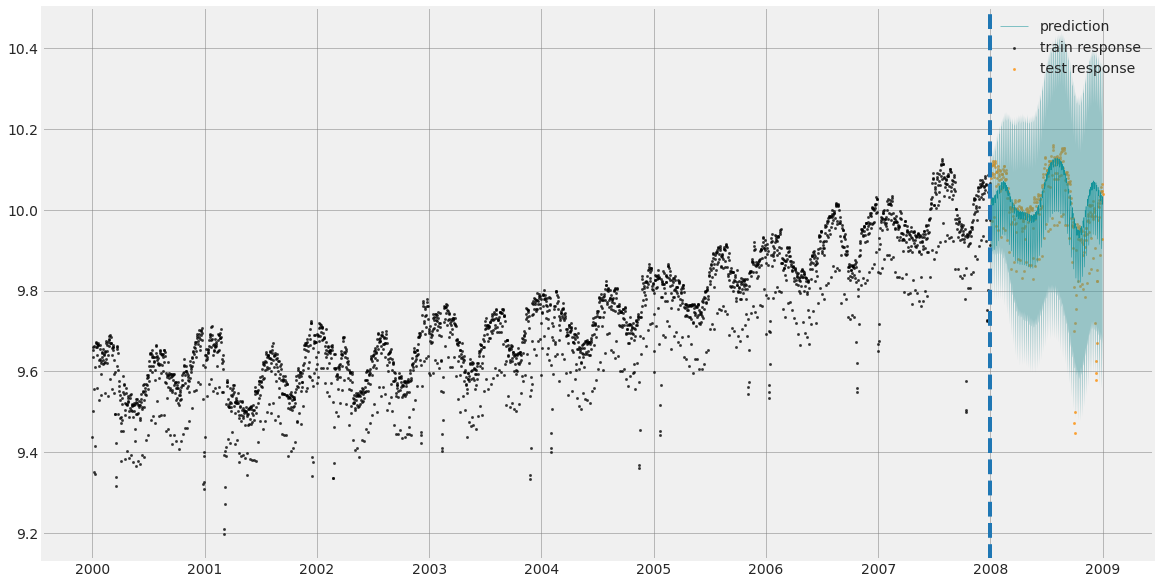

In [11]:
_ = plot_predicted_data(training_actual_df=train_df,
                        predicted_df=predicted_df, 
                        date_col=DATE_COL,
                        actual_col=RESPONSE_COL, 
                        test_actual_df=test_df,
                        markersize=20, lw=.5)

/Users/zhishiw/Desktop/uTS-py/orbit/orbit/diagnostics/plot.py:218: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.tight_layout()


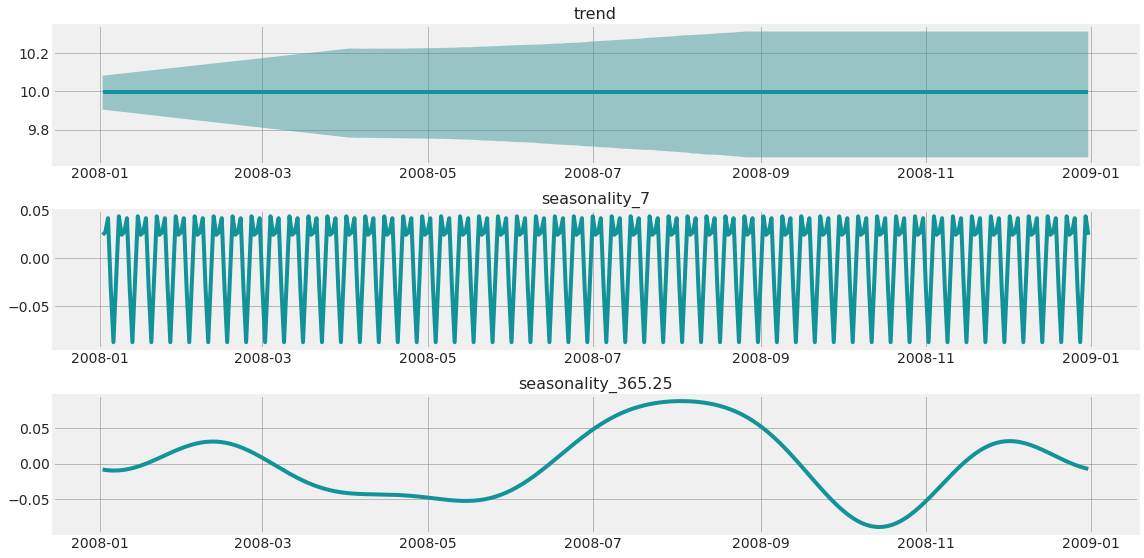

In [12]:
_ = plot_predicted_components(predicted_df=predicted_df,
                              date_col=DATE_COL, 
                              plot_components=['trend', 'seasonality_7', 'seasonality_365.25'])

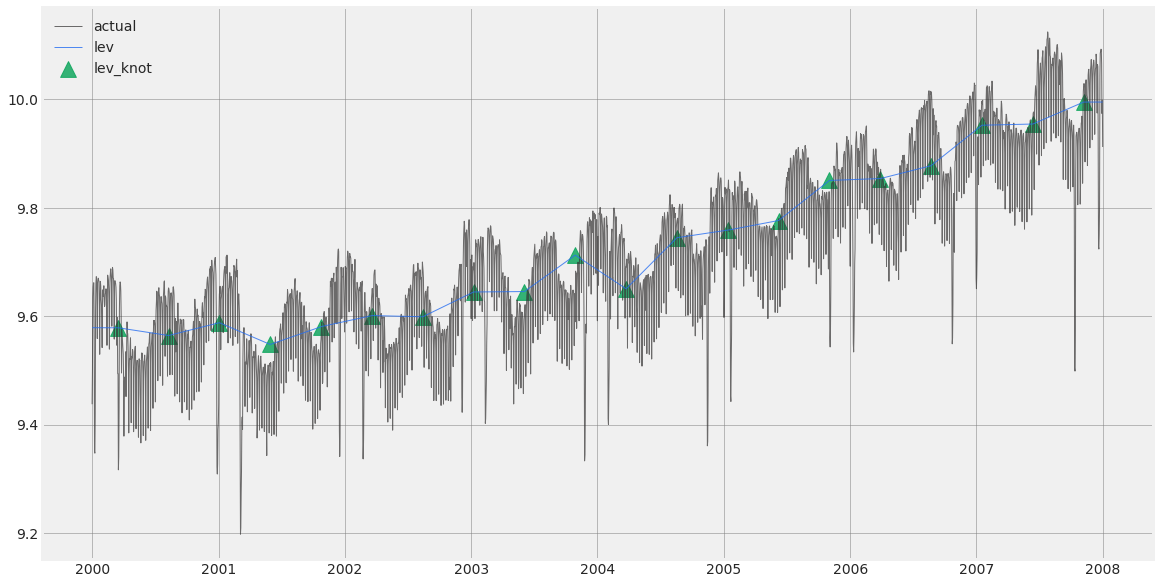

In [13]:
_ = ktrlite.plot_lev_knots()

In [14]:
lev_knots_df = ktrlite.get_level_knots()

lev_knots_df.head()

,date,lev_knot
0,2000-03-15,9.57878
1,2000-08-09,9.56434
2,2001-01-03,9.58799
3,2001-05-30,9.54782
4,2001-10-24,9.58073


In [15]:
lev_df = ktrlite.get_levels()

lev_df.head()

,date,lev
0,2000-01-01,9.57878
1,2000-01-02,9.57878
2,2000-01-03,9.57878
3,2000-01-04,9.57878
4,2000-01-05,9.57878


In [16]:
# stability check
ktrlite1 = KTRLiteMAP(response_col=RESPONSE_COL,
                      date_col=DATE_COL,
                      # seasonality
                      seasonality=[7, 365.25],
                      seasonality_fs_order=[2, 5],
                      span_coefficients=.3,
                      estimator_type=StanEstimatorMAP,
                      n_bootstrap_draws=-1,
                      seed=2020)


# stability check
ktrlite2 = KTRLiteMAP(response_col=RESPONSE_COL,
                      date_col=DATE_COL,
                      # seasonality
                      seasonality=[7, 365.25],
                      seasonality_fs_order=[2, 5],
                      span_coefficients=.3,
                      estimator_type=StanEstimatorMAP,
                      n_bootstrap_draws=-1,
                      seed=2021)

ktrlite1.fit(df)

ktrlite2.fit(df)